Daniil Panasik y Juan Quer - Análisis de Datos no Estructurados

# Práctica Imagen

Se entregan los informes. Para consultar alguna cosa más (imágenes empleadas, códigos), acceder por GitHub porque Moodle no admite más

Dataset: https://www.kaggle.com/moltean/fruits/tasks?taskId=759

El dataset contiene múltiples clases de frutas y múltiples variedades de una fruta (distintos tipos de manzanas, etc.) Son todo imágenes pequeñas del mismo tamaño.

La distribución en cuanto a directorios del dataset es la siguiente:
- Carpeta _fruits360_
    - Carpeta _Training_: contiene múltiples directorios con frutas, donde cada directorio representa una variedad de cada fruta
    - Carpeta _test-multiple_fruits_: contiene imágenes con múltiples frutas en una misma imagen
    - Carpeta _Test_: el análogo a _Training_
    
Esta práctica se divide en 3 partes y, por ende, en 3 distintos ficheros de código. En todas ellas se pretende clasificar distintas frutas.

- Una primera en la que se realizará una CNN para la clasificación. El código se encuentra en "_Practica_images_Parte1.ipynb_"
- Una segunda en la se añade la característica de _object detector_. Se empleará un modelo previamente definido de YOLO en el cual no se ha modificado nada (transfer learning). Aquí, puesto que se trata de un modelo genérico, es lógico que el resultado pueda no incluir todas las frutas de una imagen. El código se encuentra en "_Practica_images_Parte2.ipynb_"
- Una tercera y última en la que se ha realizado un _object detector_ custom. Se han elegido 3 clases de fruta distintas (manzana, banana, uva), 200 imágenes para cada una para entrenamiento y validación. Dentro de esas imágenes, puesto que hay distintas variedades, se han escogido 200/x imagenes de cada variedad, , donde 'x' representa el número de variedades que dicha fruta tiene en nuestro dataset. El código se encuentra en "_Practica_images_Parte3.ipynb_"


# Práctica Imagen - Parte 1


Importamos las librerías necesarias para implementar el modelo.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

### Preparación de los datos

Se selecciona el directorio en el que se encuentran las imágenes. A partir del comando '*/*.jpg', se pueden contar todos de los que se dispone.

In [5]:
data_dir = pathlib.Path("fruits360/Training/")
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Número de imágenes: " + str(image_count))

Número de imágenes: 67692


Definimos los parámetros del tamaño de la imagen. Además, se define el tamaño del batch.

In [7]:
batch_size = 32 # entrada que se va a propagar
img_height = 180 # tamaño de imagens altura
img_width = 180 # tamalo de imagenes anchura

Generamos el conjunto de entrenamiento, dedicándole 80% al entrenamiento y 20% a validación. 
Se dispone de 67.692 imágenes y 131 clases en total

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


A partir del directorio que se le ha pasado antes, se define el conjunto de validación restante

In [29]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


A continuación, se muestra un ejemplo de las 6 primeras variantes de fruta que hay

In [9]:
class_names = train_ds.class_names
print(class_names[:5])

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3']


Se muestra un ejemplo de las imágenes con las que se va a entrenar el modelo

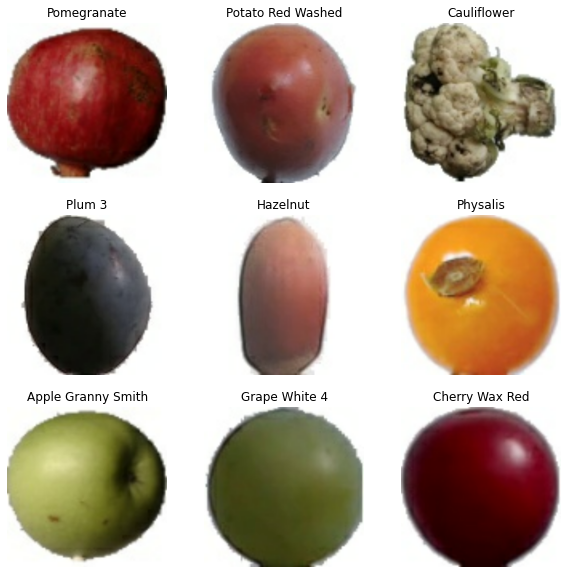

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Se mezclan las imágenes para no estar introduciendo la misma fruta de manera consecutiva

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Se introduce una capa que normaliza entre 0 y 1 los píxels de las imágenes

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [33]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.048124224 1.0


La red CNN que se emplea tiene la siguiente forma:
- La capa que normaliza
- Una capa convolucional con 16 filtros donde entra imágenes de 3x3 píxels
- Un max pooling
- Capa de 32 filtos de 3x3
- Max pooling
- Capa de 64 filtros de 3x3
- Max pooling
- Y, por último, Flatten para pasar a array la salida obtenida y poder introducirlo al clasificador DNN

El clasificador DNN está compuesto por:
- Una primera capa de 128 neuronas
- Una capa final con el número de clases que dispone nuestro dataset, 131

In [10]:
num_classes = 131

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 64)       

Se va a entrenar con 10 epochs el modelo.

In [38]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1693/1693 [==============================] - 621s 343ms/step - loss: 1.4869 - accuracy: 0.6611 - val_loss: 0.0579 - val_accuracy: 0.9827
Epoch 2/10
1693/1693 [==============================] - 571s 337ms/step - loss: 0.0569 - accuracy: 0.9843 - val_loss: 0.0033 - val_accuracy: 0.9996
Epoch 3/10
1693/1693 [==============================] - 568s 335ms/step - loss: 0.0220 - accuracy: 0.9943 - val_loss: 0.0227 - val_accuracy: 0.9927
Epoch 4/10
1693/1693 [==============================] - 754s 445ms/step - loss: 0.0199 - accuracy: 0.9945 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 5/10
1693/1693 [==============================] - 741s 438ms/step - loss: 0.0166 - accuracy: 0.9956 - val_loss: 0.0049 - val_accuracy: 0.9988
Epoch 6/10
1693/1693 [==============================] - 597s 353ms/step - loss: 0.0104 - accuracy: 0.9976 - val_loss: 0.0118 - val_accuracy: 0.9971
Epoch 7/10
1693/1693 [==============================] - 590s 348ms/step - loss: 0.0125 - accuracy: 0.9964 - val_

Se puede apreciar que conforme va avanzando el modelo, la accuracy va aumentando hasta alcanzar el 100% y el loss disminuyendo hasta ser insignificante

In [ ]:
model.save("PARTE1_modelo_frutas")